# CAD Rotation Model Analytics Notebook

Reusable utilities to prepare annotation *batches* for training a rotation‑aware detection model.
The notebook is idempotent: you can re‑run after dropping in new batches.


## README / Quick‑Start

**Directory layout expected**

```
rotation/
└── batches/
    ├── batch_20250115_01/          # <- renamed input folder
    │   ├── images/
    │   │   └── default/*.png
    │   └── annotations/
    │       └── instances_default.json
    └── ...
```

> ⚠️ If your raw data are still in `rotation/batches/images/default`  
> run section **1 – Rename batches** first.

**Requirements**

```bash
pip install pandas matplotlib pillow
```

The notebook runs entirely offline.

**Lifecycle**

1. **Rename batches** – give each batch a stable, informative folder name.  
2. **Explore JSON** – get counts of images, categories, rotated boxes.  
3. **Visual check** – overlay polygons / bboxes on random images.  
4. **(Optional) Export tidy CSV** – for downstream pipelines.


In [54]:

import os, json, shutil, random, math, datetime as dt
import cv2
import numpy as np

from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

import json, copy

import math, collections


from pathlib import Path

from matplotlib.transforms import Affine2D


plt.rcParams['figure.dpi'] = 140  # sharper inline figs


## All Files

In [49]:

# ⇩⇩ Adjust these two lines to match your project root  ⇩⇩
BATCHES_DIR = Path("../data/rotation/batches")               # or Path('/absolute/path/to/project')
IMAGE_DIR = Path("../data/rotation/batches/batch_20250703_01/images/default")               # or Path('/absolute/path/to/project')


print('Batches dir  :', BATCHES_DIR)



Batches dir  : ../data/rotation/batches


## 2 – Explore a COCO JSON file

In [ ]:

def load_coco(json_path: Path) -> Dict[str, Any]:
    with open(json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)
        print(f"coco{coco}")
    return coco



def coco_summary(coco: Dict[str, Any]) -> None:
    print(f"Images      : {len(coco['images']):>5}")
    print(f"Annotations : {len(coco['annotations']):>5}")
    print(f"Categories  : {len(coco['categories']):>5}\n")
    cat_map = {c['id']: c['name'] for c in coco['categories']}
    counts = {}
    for ann in coco['annotations']:
        counts[cat_map[ann['category_id']]] = counts.get(cat_map[ann['category_id']], 0) + 1
    print('Top classes:')
    for k, v in sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:10]:
        print(f"  {k:<25} {v}")

def coco_to_df(coco: Dict[str, Any]) -> pd.DataFrame:
    img_lookup = {img['id']: img for img in coco['images']}
    rows = []
    for ann in coco['annotations']:
        img = img_lookup[ann['image_id']]
        row = {
            'image_id': ann['image_id'],
            'file_name': img['file_name'],
            'width': img['width'],
            'height': img['height'],
            'category_id': ann['category_id'],
            'bbox': ann['bbox'],
            'area': ann.get('area', None),
            'rotation': ann.get('attributes', {}).get('rotation', 0.0),
            'iscrowd': ann.get('iscrowd', 0)
        }
        rows.append(row)
    return pd.DataFrame(rows)


In [57]:
# ────────────────────────────────────────────────────────────────
# 3.  Pick (and sanity-check) a batch folder
# ────────────────────────────────────────────────────────────────
subdirs = sorted(p for p in BATCHES_DIR.iterdir() if p.is_dir())
if not subdirs:
    raise FileNotFoundError(f"No batch folders found in {BATCHES_DIR.resolve()}")

first_batch = subdirs[0]
print("Using batch :", first_batch.name)

# ────────────────────────────────────────────────────────────────
# 4.  Load, summarise, flatten
# ────────────────────────────────────────────────────────────────
json_path = first_batch / "annotations" / "instances_default.json"
coco      = load_coco(json_path)

coco_summary(coco)

df = coco_to_df(coco)
display(df.head(5))     

Using batch : batch_20250703_01
coco{'licenses': [{'name': '', 'id': 0, 'url': ''}], 'info': {'contributor': '', 'date_created': '', 'description': '', 'url': '', 'version': '', 'year': ''}, 'categories': [{'id': 1, 'name': 'isOk', 'supercategory': ''}, {'id': 2, 'name': 'inner-edge-', 'supercategory': ''}, {'id': 3, 'name': 'additional-infoblock', 'supercategory': ''}, {'id': 4, 'name': 'inner-edge-tolerance', 'supercategory': ''}, {'id': 5, 'name': 'infoblock', 'supercategory': ''}, {'id': 6, 'name': 'gdt', 'supercategory': ''}, {'id': 7, 'name': 'text', 'supercategory': ''}, {'id': 8, 'name': 'additional infoblock', 'supercategory': ''}, {'id': 9, 'name': 'surface-roughness', 'supercategory': ''}, {'id': 10, 'name': 'welding_symbol', 'supercategory': ''}, {'id': 11, 'name': 'infoBlock', 'supercategory': ''}, {'id': 12, 'name': 'general-chamfer', 'supercategory': ''}, {'id': 13, 'name': 'drawing-area', 'supercategory': ''}], 'images': [{'id': 1, 'width': 3055, 'height': 2160, 'file_n

,image_id,file_name,width,height,category_id,bbox,area,rotation,iscrowd
0,1,10000.png,3055,2160,7,"[2434.51, 533.13, 35.37, 32.47]",1148.4639,314.6,0
1,1,10000.png,3055,2160,7,"[1165.9, 1001.1, 49.4, 18.9]",933.6600,0.0,0
2,1,10000.png,3055,2160,7,"[1165.7, 1021.8, 49.74, 19.2]",955.0080,0.0,0
3,1,10000.png,3055,2160,7,"[2234.5, 1021.9, 34.1, 19.3]",658.1300,0.0,0
4,1,10000.png,3055,2160,7,"[2175.8, 1006.5, 47.5, 37.8]",1795.5000,0.0,0


In [58]:


images_dir  = IMAGE_DIR             



with json_path.open() as f:
    coco = json.load(f)

# build a pandas table so it's easy to query and plot
df_ann = pd.DataFrame(coco["annotations"])
df_img = pd.DataFrame(coco["images"])

# merge the two so every row already has its image filename
df_all = df_ann.merge(df_img[["id", "file_name", "width", "height"]],
                  left_on="image_id", right_on="id",
                  suffixes=("", "_img"))

df_all["rotation"] = df_all["attributes"].apply(lambda x: x.get("rotation", 0.0) if isinstance(x, dict) else 0.0)



df_all.head()




,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes,id_img,file_name,width,height,rotation
0,1,1,7,[],1148.4639,"[2434.51, 533.13, 35.37, 32.47]",0,"{'occluded': False, 'rotation': 314.6}",1,10000.png,3055,2160,314.6
1,2,1,7,[],933.6600,"[1165.9, 1001.1, 49.4, 18.9]",0,"{'occluded': False, 'rotation': 0.0}",1,10000.png,3055,2160,0.0
2,3,1,7,[],955.0080,"[1165.7, 1021.8, 49.74, 19.2]",0,"{'occluded': False, 'rotation': 0.0}",1,10000.png,3055,2160,0.0
3,4,1,7,[],658.1300,"[2234.5, 1021.9, 34.1, 19.3]",0,"{'occluded': False, 'rotation': 0.0}",1,10000.png,3055,2160,0.0
4,5,1,7,[],1795.5000,"[2175.8, 1006.5, 47.5, 37.8]",0,"{'occluded': False, 'rotation': 0.0}",1,10000.png,3055,2160,0.0


Index(['image_id', 'file_name', 'width', 'height', 'category_id', 'bbox',
       'area', 'rotation', 'iscrowd'],
      dtype='object')
Subset Head:   image_id  file_name  width  height  category_id  \
0         1  10000.png   3055    2160            7   
1         1  10000.png   3055    2160            7   
2         1  10000.png   3055    2160            7   
3         1  10000.png   3055    2160            7   
4         1  10000.png   3055    2160            7   

                              bbox       area  rotation  iscrowd  
0  [2434.51, 533.13, 35.37, 32.47]  1148.4639     314.6        0  
1     [1165.9, 1001.1, 49.4, 18.9]   933.6600       0.0        0  
2    [1165.7, 1021.8, 49.74, 19.2]   955.0080       0.0        0  
3     [2234.5, 1021.9, 34.1, 19.3]   658.1300       0.0        0  
4     [2175.8, 1006.5, 47.5, 37.8]  1795.5000       0.0        0  


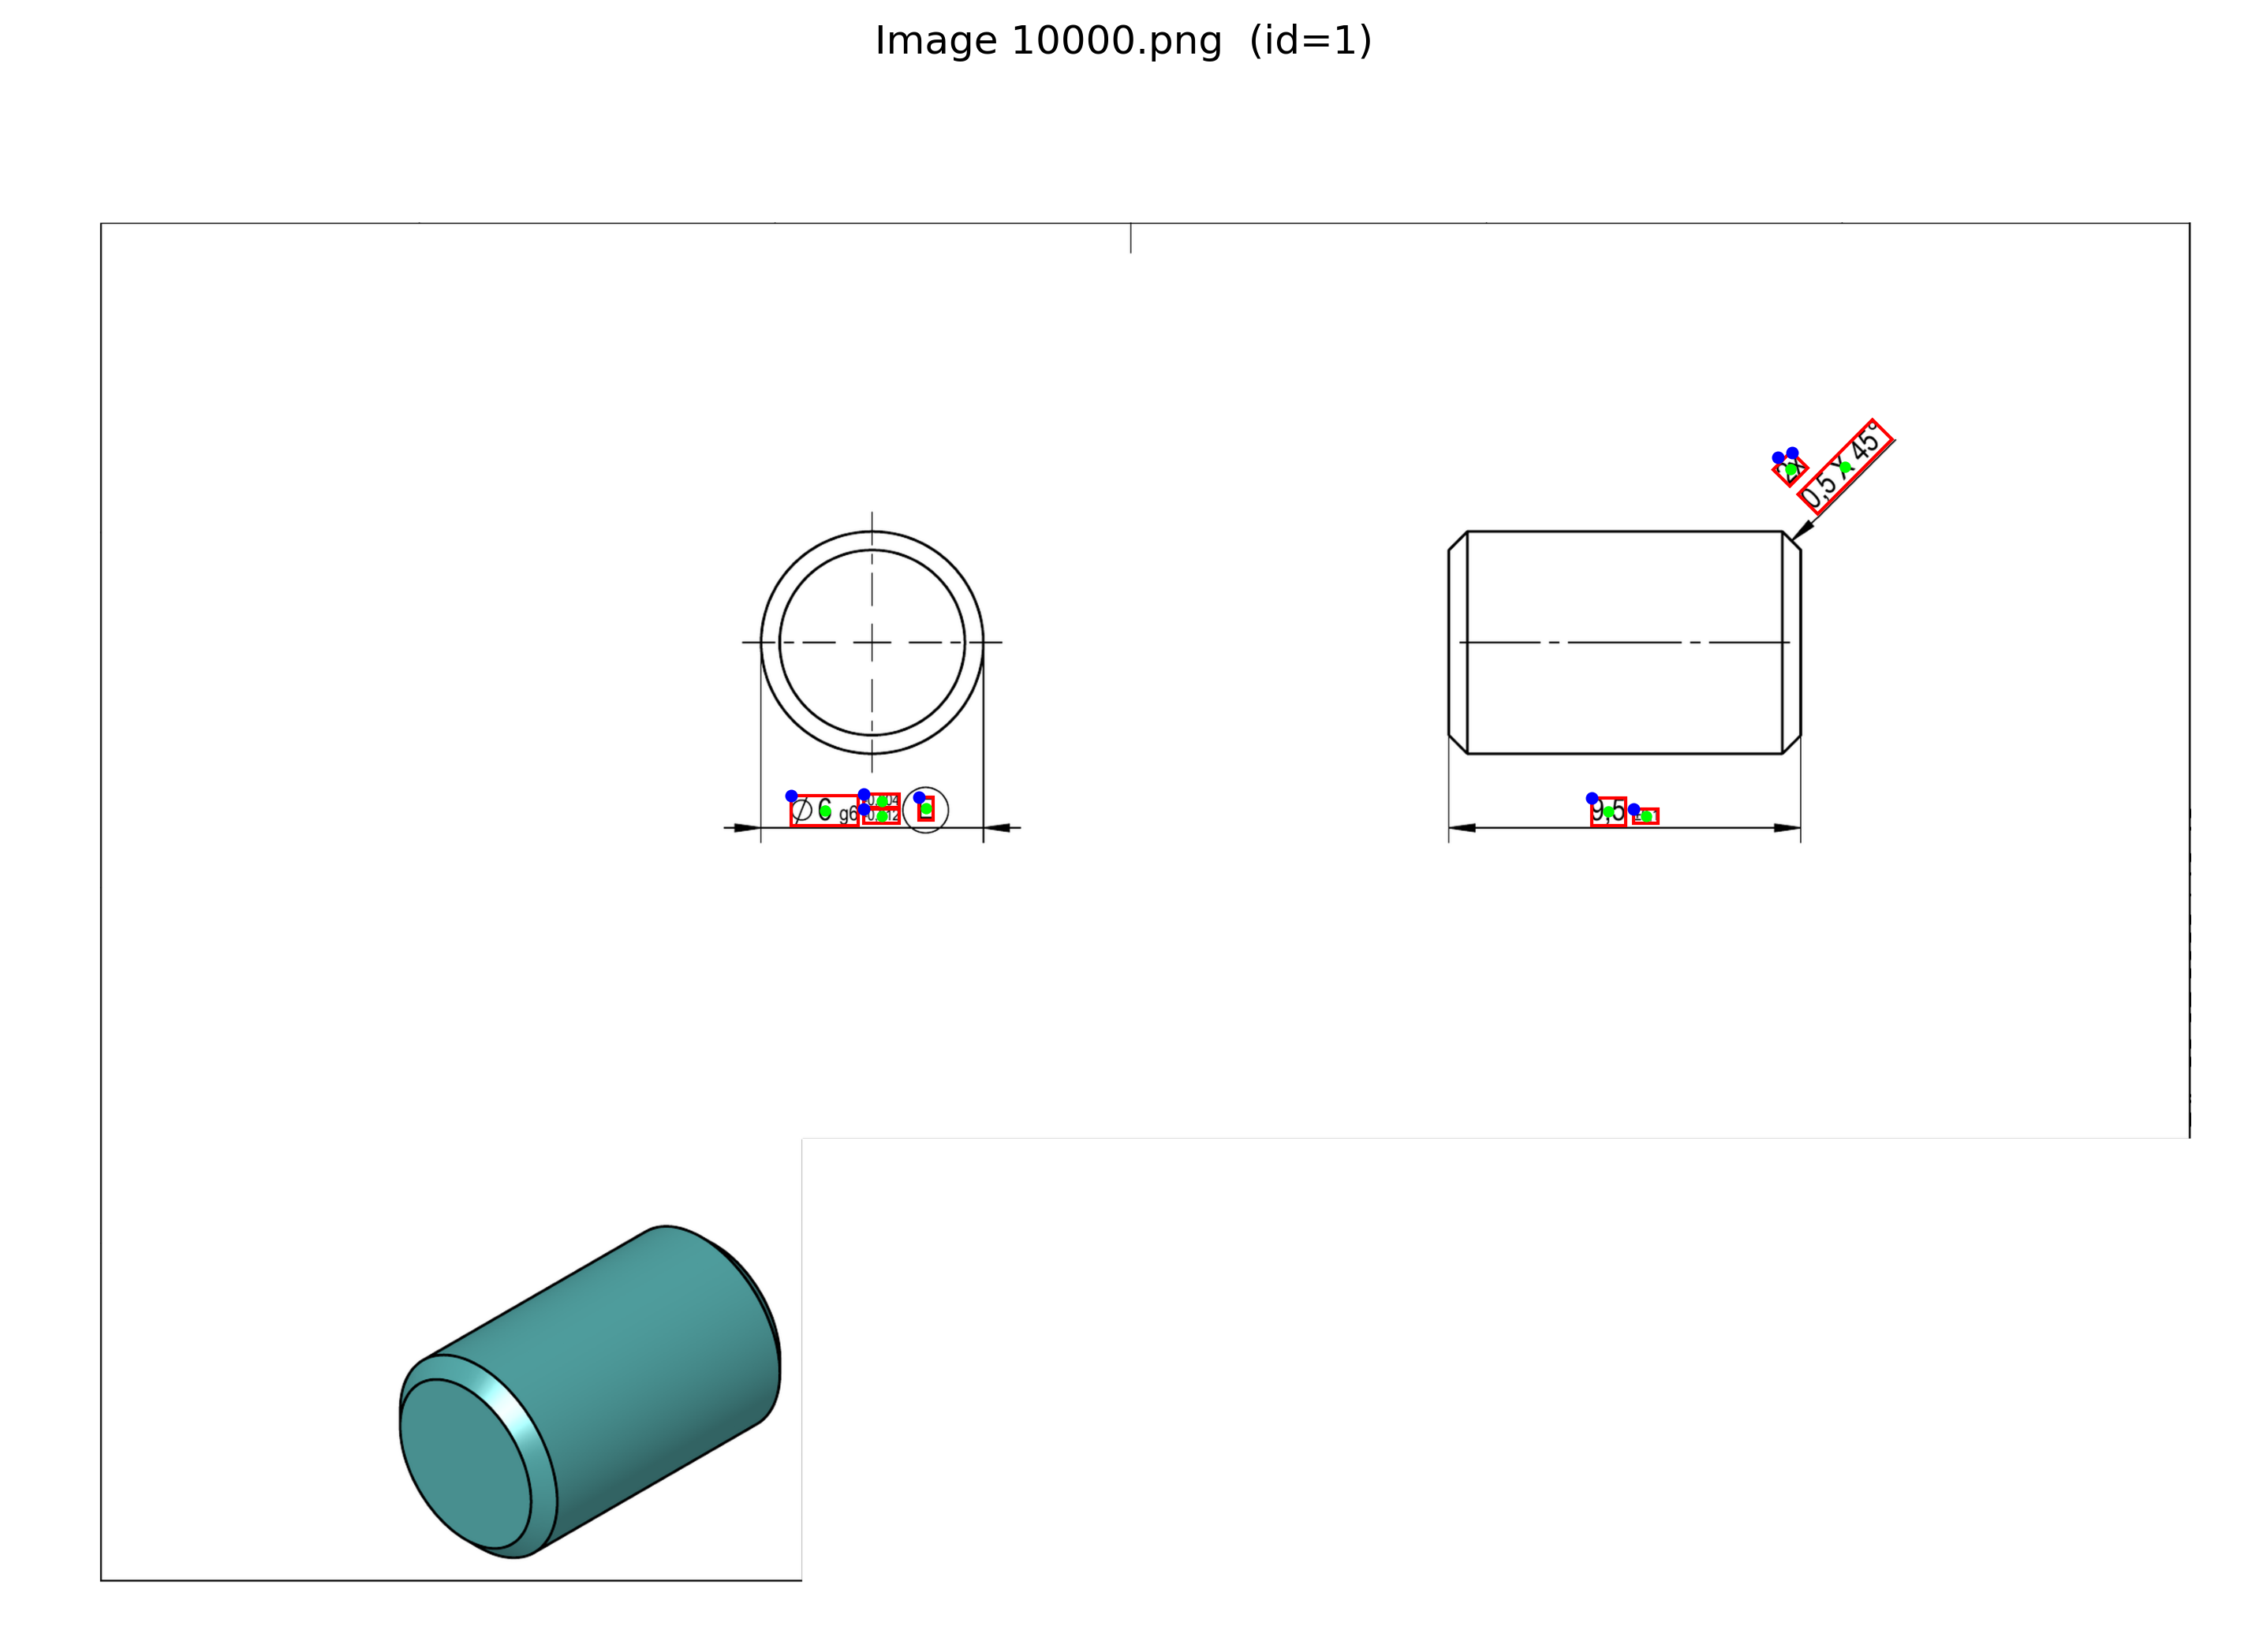

In [61]:
# 2.  visualiser 
def show_image_with_annotations(row_img: pd.Series,
                                df_all: pd.DataFrame,
                                images_dir: Path,
                                show_centres: bool = True,
                                centre_color: str = "lime") -> None:
    """
    Display one COCO image with *all* its (possibly rotated) bboxes.
    Assumes:
        * df_all has columns  bbox (x, y, w, h)  and  rotation  (° clockwise)
    """
    img_path = images_dir / row_img["file_name"]
    
    if not img_path.exists():
        print("Image not found:", img_path)
        return

    # ---- image and axes 
    img = plt.imread(img_path)
    fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
    ax.imshow(img, aspect="equal")
    ax.set_title(f'Image {row_img["file_name"]}  (id={row_img["id"]})')
    ax.axis("off")

    # ---- annotations for this image -------------------------------
    subset = df_all[df_all["image_id"] == row_img["id"]]
    
    print(subset.columns)
    
    print(f"Subset Head:{subset.head()}")

    # Print a little debug table
   # print(subset[["image_id", "bbox", "rotation"]])

    for _, ann in subset.iterrows():
        x, y, w, h = ann["bbox"]
        rot_cw = ann["rotation"]          # clockwise  → negate for CCW

        # 1️⃣ scatter the COCO anchor (top-left)
        ax.scatter(x, y, color="blue", s=8, zorder=3)

        # 2️⃣ build an unrotated rectangle whose *centre* is (cx, cy)
        cx, cy = x + w / 2, y + h / 2
        rect = Rectangle((cx - w / 2, cy - h / 2), w, h,
                         linewidth=1, edgecolor="red", fill=False)

        # 3️⃣ rotate about the centre.  Matplotlib expects CCW.
        transf = Affine2D().rotate_deg_around(cx, cy, rot_cw) + ax.transData
        rect.set_transform(transf)
        ax.add_patch(rect)

        # optional: mark the centre too
        if show_centres:
            ax.scatter(cx, cy, color=centre_color, s=6, zorder=3)

    plt.show()


# -------------------------------------------------------------------
# 3.  pick an image and visualise -----------------------------------
# -------------------------------------------------------------------


# pick the 5th image (index 4) like you did:
row = df_img.iloc[0]
show_image_with_annotations(row_img=row,
                            df_all=df,
                            images_dir=images_dir)



In [36]:
# ╔══════════════════════════════════════════════════════════════╗
#  Dataset analytics helpers
#  • works with the 5-tuple (cx,cy,w,h,θ) COCO you just created
#  • requires pandas & matplotlib     pip install pandas matplotlib
# ╚══════════════════════════════════════════════════════════════╝




def coco_to_df(coco: Dict[str, Any]) -> pd.DataFrame:
    """Flatten COCO annotations (with rotated bbox) into a tidy DataFrame."""
    img_lookup = {img["id"]: img for img in coco["images"]}
    rows = []
    for ann in coco["annotations"]:
        cx, cy, w, h, theta = ann["bbox"]
        rows.append({
            "ann_id"     : ann["id"],
            "image_id"   : ann["image_id"],
            "file_name"  : img_lookup[ann["image_id"]]["file_name"],
            "img_width"  : img_lookup[ann["image_id"]]["width"],
            "img_height" : img_lookup[ann["image_id"]]["height"],
            "category_id": ann["category_id"],
            "cx"         : cx,
            "cy"         : cy,
            "w"          : w,
            "h"          : h,
            "theta"      : theta,                 # clockwise, degrees
            "area"       : ann.get("area"),
            "iscrowd"    : ann.get("iscrowd", 0),
        })
    return pd.DataFrame(rows)

# ───────────────────── theta exploration ───────────────────────
def analyze_theta(df: pd.DataFrame,
                  nbins: int = 36,
                  show_hist: bool = True) -> None:
    """
    Prints descriptive stats of the rotation angle column and shows a histogram.
    Assumes angles are in degrees, clockwise, any range.
    """
    theta = df["theta"].astype(float)

    # Normalise to (-180, 180] so statistics make sense
    theta_norm = ((theta + 180) % 360) - 180

    print("θ  statistics (degrees, clockwise)")
    print(f"  count:    {len(theta_norm):>6}")
    print(f"  mean:     {theta_norm.mean():8.2f}")
    print(f"  std dev:  {theta_norm.std():8.2f}")
    print(f"  min/max:  {theta_norm.min():8.2f}  …  {theta_norm.max():8.2f}")

    # Top 10 most frequent angles (useful when labels are snapped to 0/90/180/270)
    top = theta_norm.round(1).value_counts().head(10)
    print("\n  most frequent angles:")
    for ang, cnt in top.items():
        print(f"    {ang:6.1f}°   {cnt:>6}")

    if show_hist:
        plt.figure(figsize=(6,4))
        plt.hist(theta_norm, bins=nbins, edgecolor="black")
        plt.title("θ distribution")
        plt.xlabel("θ (deg, clockwise; wrapped to -180…180)")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

# ─────────────────── image-level exploration ───────────────────
def analyze_images(coco: Dict[str, Any],
                   top_k: int = 5) -> None:
    """
    Prints image resolution stats and other handy counts.
    """
    widths  = [img["width"]  for img in coco["images"]]
    heights = [img["height"] for img in coco["images"]]
    areas   = [w*h for w, h in zip(widths, heights)]

    print("Image statistics")
    print(f"  total images:       {len(widths):>6}")
    print(f"  size (min / med / max)  :")
    print(f"     width : {min(widths):>6}  …  {int(pd.Series(widths).median()):>6}  …  {max(widths):>6}")
    print(f"     height: {min(heights):>6}  …  {int(pd.Series(heights).median()):>6}  …  {max(heights):>6}")
    print(f"     area  : {min(areas):>8} px² … {int(pd.Series(areas).median()):>8} … {max(areas):>8}")

    # landscape / portrait / square counts
    orientation = collections.Counter(
        "landscape" if w >= h else "portrait" if h > w else "square"
        for w, h in zip(widths, heights)
    )
    print("\n  orientation counts:")
    for k, v in orientation.items():
        print(f"    {k:<12}: {v}")

    # most common individual resolutions
    reso = collections.Counter((w, h) for w, h in zip(widths, heights))
    print(f"\n  top {top_k} resolutions:")
    for (w, h), cnt in reso.most_common(top_k):
        print(f"    {w:>4}×{h:<4}   {cnt} images")



coco{'licenses': [{'name': '', 'id': 0, 'url': ''}], 'info': {'contributor': '', 'date_created': '', 'description': '', 'url': '', 'version': '', 'year': ''}, 'categories': [{'id': 1, 'name': 'isOk', 'supercategory': ''}, {'id': 2, 'name': 'inner-edge-', 'supercategory': ''}, {'id': 3, 'name': 'additional-infoblock', 'supercategory': ''}, {'id': 4, 'name': 'inner-edge-tolerance', 'supercategory': ''}, {'id': 5, 'name': 'infoblock', 'supercategory': ''}, {'id': 6, 'name': 'gdt', 'supercategory': ''}, {'id': 7, 'name': 'text', 'supercategory': ''}, {'id': 8, 'name': 'additional infoblock', 'supercategory': ''}, {'id': 9, 'name': 'surface-roughness', 'supercategory': ''}, {'id': 10, 'name': 'welding_symbol', 'supercategory': ''}, {'id': 11, 'name': 'infoBlock', 'supercategory': ''}, {'id': 12, 'name': 'general-chamfer', 'supercategory': ''}, {'id': 13, 'name': 'drawing-area', 'supercategory': ''}], 'images': [{'id': 1, 'width': 3055, 'height': 2160, 'file_name': '10000.png', 'license': 0,

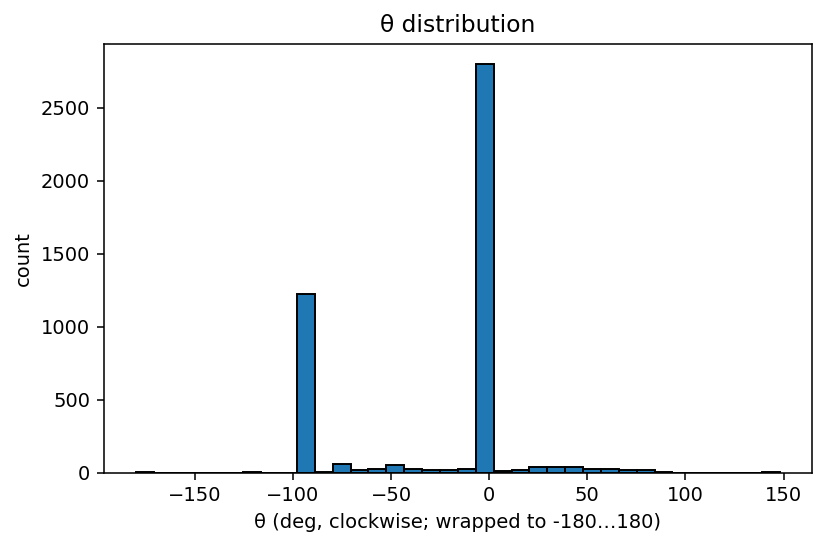

Image statistics
  total images:           97
  size (min / med / max)  :
     width :   2160  …    3055  …    6617
     height:   2160  …    2160  …    4678
     area  :  6039360 px² …  6598800 … 30954326

  orientation counts:
    landscape   : 72
    portrait    : 25

  top 5 resolutions:
    3056×2160   27 images
    3054×2160   12 images
    2160×3055   11 images
    3055×2160   9 images
    2160×3054   9 images


In [37]:

# ════════════════════════════════════════════════════════════════
#  Example usage
# ════════════════════════════════════════════════════════════════
json_path = Path("../data/rotation/batches/batch_20250703_01/annotations/instances_updated.json")
coco      = load_coco(json_path)
df        = coco_to_df(coco)

analyze_theta(df)     # ↩️ prints stats + shows histogram
analyze_images(coco)  # ↩️ prints resolution info


θ  statistics (degrees, clockwise)
  count:      4435
  mean:       -26.70
  std dev:     46.23
  min/max:   -180.00  …    179.70

  most frequent angles:
       0.0°     2240
     -90.0°     1053
       0.1°       74
       0.2°       39
     -90.1°       33
      -0.1°       33
     -89.9°       29
      -0.3°       26
       0.3°       23
       0.6°       23


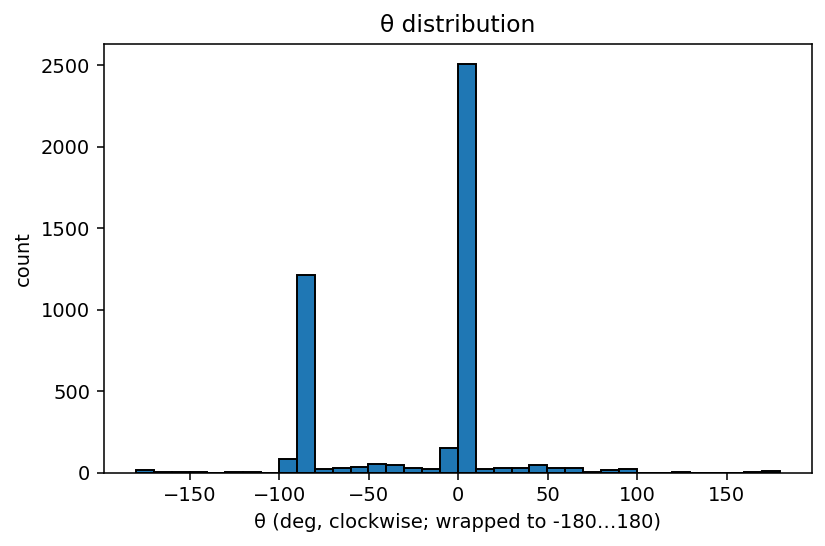

Image statistics
  total images:          100
  size (min / med / max)  :
     width :   2160  …    3055  …    3840
     height:   2160  …    2160  …    3057
     area  :  6220800 px² …  6598800 …  8294400

  orientation counts:
    portrait    : 27
    landscape   : 73

  top 5 resolutions:
    3056×2160   29 images
    3054×2160   13 images
    2160×3055   13 images
    3055×2160   9 images
    3057×2160   7 images


In [ ]:

# ════════════════════════════════════════════════════════════════
#  Example usage
# ════════════════════════════════════════════════════════════════
json_path = Path("../data/rotation/batches/batch_20250703_02/annotations/instances_updated.json")
coco      = load_coco(json_path)
df        = coco_to_df(coco)

analyze_theta(df)     # ↩️ prints stats + shows histogram
analyze_images(coco)  # ↩️ prints resolution info
